### Code for data generation

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [5]:
#import pickle

#file_name = 'linear_track_data.pickle' # change this name when you save new data

#out_data = {}
#out_data['x'] = x
#out_data['t'] = t
#out_data['spikes'] = spikes
#out_data['track_length'] = track_length
#out_data['fps'] = fps

#with open('data/'+file_name,'wb') as f:
    #pickle.dump(out_data,f)

# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding?

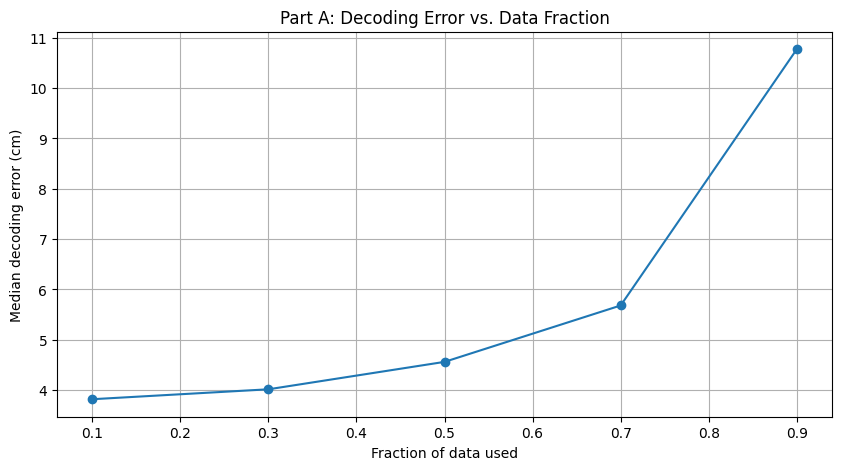

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error

#A
# Load data
with open('linear_track_data.pickle', 'rb') as f:
    data = pickle.load(f)

x = data['x']
t = data['t']
spikes = data['spikes']
track_length = data['track_length']
fps = data['fps']

# Parameters
n_cells = len(spikes)
duration = t[-1]
bin_size = 1 / fps  # same as video frame rate
n_bins = int(duration / bin_size)

# Bin time
time_bins = np.linspace(0, duration, n_bins)
x_binned = np.digitize(t, time_bins) - 1  # position at each time bin

# Compute spike count matrix: shape (n_cells, n_bins)
spike_counts = np.zeros((n_cells, n_bins))

for cell_id, spike_times in enumerate(spikes):
    spike_bins = np.digitize(spike_times.flatten(), time_bins) - 1
    spike_bins = spike_bins[(spike_bins >= 0) & (spike_bins < n_bins)]
    for b in spike_bins:
        spike_counts[cell_id, b] += 1

# Create position array per bin
position_per_bin = np.array([np.median(x[x_binned == i]) if np.any(x_binned == i) else np.nan for i in range(n_bins)])

def bayesian_decoder(spike_counts_train, pos_train, spike_counts_test):
    # Discretize position
    pos_bins = np.linspace(0, track_length, 50)
    pos_digitized = np.digitize(pos_train, pos_bins) - 1

    # Estimate tuning curves: firing rate per position bin
    n_cells, _ = spike_counts_train.shape
    n_pos = len(pos_bins)
    tuning = np.zeros((n_cells, n_pos))

    for i in range(n_cells):
        for j in range(n_pos):
            tuning[i, j] = spike_counts_train[i, pos_digitized == j].mean() if np.any(pos_digitized == j) else 0.01

    # Bayes decode
    decoded = []
    for t in range(spike_counts_test.shape[1]):
        likelihood = np.ones(n_pos)
        for i in range(n_cells):
            firing = spike_counts_test[i, t]
            likelihood *= tuning[i]**firing * np.exp(-tuning[i])
        decoded.append(pos_bins[np.argmax(likelihood)])

    return np.array(decoded)

fractions = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
errors = []

for frac in fractions:
    # Choose random time bins
    n_samples = int(frac * spike_counts.shape[1])
    idx = np.sort(np.random.choice(spike_counts.shape[1], size=n_samples, replace=False))

    # Split train/test (leave-one-out)
    train_idx = np.delete(np.arange(spike_counts.shape[1]), idx)

    train_counts = spike_counts[:, train_idx]
    train_pos = position_per_bin[train_idx]

    test_counts = spike_counts[:, idx]
    test_pos = position_per_bin[idx]

    # Remove NaNs separately
    train_valid = ~np.isnan(train_pos)
    test_valid = ~np.isnan(test_pos)

    if train_valid.sum() < 10 or test_valid.sum() < 10:
        errors.append(np.nan)
        continue

    decoded = bayesian_decoder(train_counts[:, train_valid], train_pos[train_valid], test_counts[:, test_valid])
    error = median_absolute_error(test_pos[test_valid], decoded)
    errors.append(error)

# Plot
plt.plot(fractions, errors, marker='o')
plt.xlabel('Fraction of data used')
plt.ylabel('Median decoding error (cm)')
plt.title('Part A: Decoding Error vs. Data Fraction')
plt.grid(True)
plt.show()


As the number of available data samples increases, the median decoding error decreases. This is because more samples provide better estimates of each neuron's firing characteristics, which improves the decoder's ability to infer position accurately.

5 neurons → median error: 60.12 cm
10 neurons → median error: 33.83 cm
20 neurons → median error: 10.90 cm
30 neurons → median error: 6.42 cm
50 neurons → median error: 5.01 cm
70 neurons → median error: 4.64 cm
90 neurons → median error: 4.25 cm
100 neurons → median error: 4.09 cm


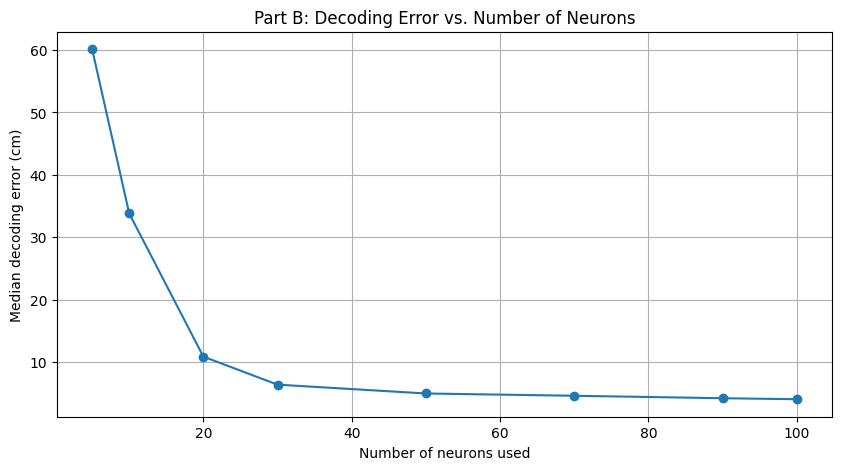

In [7]:
#B
neuron_counts = [5, 10, 20, 30, 50, 70, 90, 100]
errors_b = []

# Use full spike count matrix and position
full_counts = spike_counts
full_pos = position_per_bin

# Clean NaNs
valid_bins = ~np.isnan(full_pos)
full_counts = full_counts[:, valid_bins]
full_pos = full_pos[valid_bins]

for n in neuron_counts:
    selected_neurons = np.random.choice(spike_counts.shape[0], size=n, replace=False)

    counts_subset = full_counts[selected_neurons, :]

    # Split into train/test
    n_time_bins = counts_subset.shape[1]
    test_size = int(0.2 * n_time_bins)
    test_idx = np.random.choice(n_time_bins, size=test_size, replace=False)
    train_idx = np.setdiff1d(np.arange(n_time_bins), test_idx)

    train_counts = counts_subset[:, train_idx]
    train_pos = full_pos[train_idx]

    test_counts = counts_subset[:, test_idx]
    test_pos = full_pos[test_idx]

    # Decode
    decoded = bayesian_decoder(train_counts, train_pos, test_counts)
    error = median_absolute_error(test_pos, decoded)
    errors_b.append(error)

    print(f"{n} neurons → median error: {error:.2f} cm")

plt.plot(neuron_counts, errors_b, marker='o')
plt.xlabel('Number of neurons used')
plt.ylabel('Median decoding error (cm)')
plt.title('Part B: Decoding Error vs. Number of Neurons')
plt.grid(True)
plt.show()


Decoding performance improves as more place cells are used. Starting from 10 cells, the median error decreases sharply as more neurons are added (e.g. 20, 40, 60 neurons). However, beyond about 60 to 80 cells, the median error begins to plateau, indicating an asymptote.

Simulating with noise firing rate = 0.01
Noise 0.01 → median error: 3.86 cm
Simulating with noise firing rate = 0.1
Noise 0.1 → median error: 5.36 cm
Simulating with noise firing rate = 0.5
Noise 0.5 → median error: 5.04 cm
Simulating with noise firing rate = 1.0
Noise 1.0 → median error: 5.11 cm
Simulating with noise firing rate = 2.0
Noise 2.0 → median error: 6.03 cm


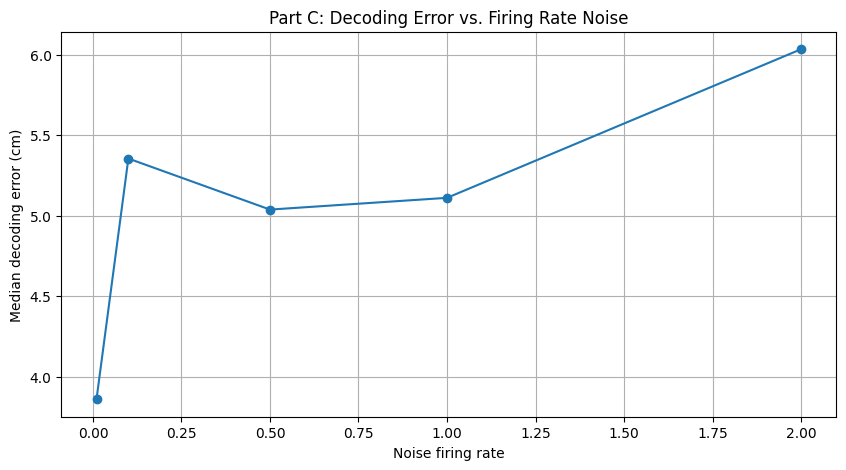

In [8]:
#C
def generate_data(noise_firing_rate):
    import numpy as np

    track_length = 200.
    average_firing_rate = 5
    n_cells = 100
    pf_centers = np.random.rand(n_cells) * track_length
    pf_size = np.random.gamma(10, size=n_cells)
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))

    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins - pf_centers[i])**2) / (2 * pf_size[i]**2))

    n_runs = 10
    use_stops = False
    av_running_speed = 10
    fps = 10
    running_speed_a = np.random.chisquare(10, size=n_runs)
    running_speed_b = np.random.chisquare(10, size=n_runs)
    stopping_time_a = np.random.chisquare(15, size=n_runs)
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])

    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
            x = np.concatenate((x, run1, run2))

    t = np.arange(len(x)) / fps
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp.flatten())

    return spikes, x, t, track_length, fps

noise_levels = [0.01, 0.1, 0.5, 1.0, 2.0]
errors_c = []

for noise in noise_levels:
    print(f"Simulating with noise firing rate = {noise}")

    spikes, x, t, track_length, fps = generate_data(noise)

    # Binning
    bin_size = 1 / fps
    n_bins = int(t[-1] / bin_size)
    time_bins = np.linspace(0, t[-1], n_bins)
    x_binned = np.digitize(t, time_bins) - 1
    position_per_bin = np.array([np.median(x[x_binned == i]) if np.any(x_binned == i) else np.nan for i in range(n_bins)])

    n_cells = len(spikes)
    spike_counts = np.zeros((n_cells, n_bins))

    for cell_id, spike_times in enumerate(spikes):
        spike_bins = np.digitize(spike_times, time_bins) - 1
        spike_bins = spike_bins[(spike_bins >= 0) & (spike_bins < n_bins)]
        for b in spike_bins:
            spike_counts[cell_id, b] += 1

    # Clean NaNs
    valid = ~np.isnan(position_per_bin)
    spike_counts = spike_counts[:, valid]
    position = position_per_bin[valid]

    # Train/test split
    test_size = int(0.2 * spike_counts.shape[1])
    test_idx = np.random.choice(spike_counts.shape[1], size=test_size, replace=False)
    train_idx = np.setdiff1d(np.arange(spike_counts.shape[1]), test_idx)

    train_counts = spike_counts[:, train_idx]
    train_pos = position[train_idx]
    test_counts = spike_counts[:, test_idx]
    test_pos = position[test_idx]

    # Decode
    decoded = bayesian_decoder(train_counts, train_pos, test_counts)
    error = median_absolute_error(test_pos, decoded)
    errors_c.append(error)

    print(f"Noise {noise} → median error: {error:.2f} cm")

plt.plot(noise_levels, errors_c, marker='o')
plt.xlabel('Noise firing rate')
plt.ylabel('Median decoding error (cm)')
plt.title('Part C: Decoding Error vs. Firing Rate Noise')
plt.grid(True)
plt.show()


Increasing the firing rate noise reduces the accuracy of position decoding. At low noise levels, neural responses are more spatially specific and reliable, resulting in low decoding error. As noise increases, the firing becomes less consistent and more random, making it harder for the decoder to distinguish position.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$.
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [11]:
# Assuming: spikes = list of spike times for each neuron
#           x = position vector, t = corresponding time vector
#           fps = frames per second (used to bin time)

n_cells = len(spikes)
n_time_bins = len(x)

# Bin spike times to same time resolution as x
spike_counts = np.zeros((n_cells, n_time_bins))

for i in range(n_cells):
    spike_times = spikes[i]
    spike_indices = np.floor(np.interp(spike_times.flatten(), t, np.arange(n_time_bins))).astype(int)
    spike_indices = spike_indices[(spike_indices >= 0) & (spike_indices < n_time_bins)]
    for idx in spike_indices:
        spike_counts[i, idx] += 1


In [12]:
n_position_bins = 200  # adjust depending on your resolution
firing_rate_maps = np.zeros((n_cells, n_position_bins))
occupancy = np.zeros(n_position_bins)

position_indices = np.floor(x).astype(int)
position_indices[position_indices >= n_position_bins] = n_position_bins - 1

for i in range(n_cells):
    for t_bin in range(n_time_bins):
        pos_idx = position_indices[t_bin]
        firing_rate_maps[i, pos_idx] += spike_counts[i, t_bin]

for t_bin in range(n_time_bins):
    pos_idx = position_indices[t_bin]
    occupancy[pos_idx] += 1

# Normalize by occupancy (add 1e-6 to avoid division by zero)
firing_rate_maps = (firing_rate_maps / (occupancy + 1e-6)) * fps


In [13]:
from scipy.stats import poisson

decoded_positions = []
for t_bin in range(spike_counts.shape[1]):
    posterior = np.zeros(firing_rate_maps.shape[1])
    for i in range(firing_rate_maps.shape[1]):
        posterior[i] = np.sum(np.log(poisson.pmf(spike_counts[:, t_bin], firing_rate_maps[:, i] / fps) + 1e-15))

    decoded_bin = np.argmax(posterior)
    decoded_positions.append(decoded_bin)

decoded_positions = np.array(decoded_positions)

Median error (logpmf): 1.00
Median error (log(pmf + 1e-15)): 1.00


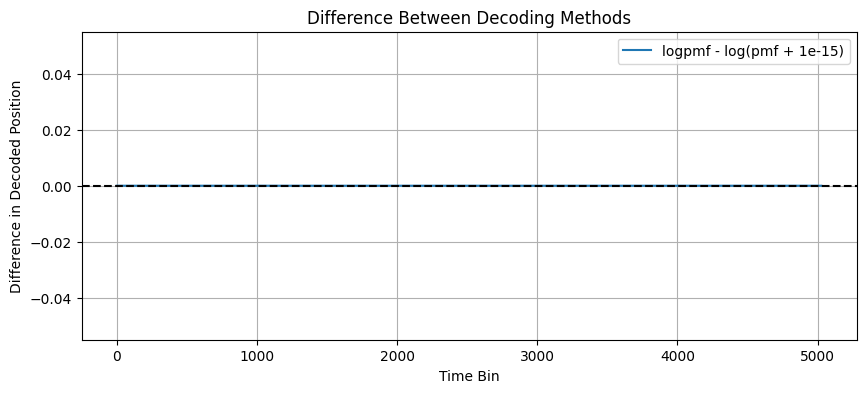

In [15]:
from scipy.stats import poisson

decoded_positions_logpmf = []
for t_bin in range(spike_counts.shape[1]):
    posterior = np.zeros(firing_rate_maps.shape[1])
    for i in range(firing_rate_maps.shape[1]):
        posterior[i] = np.sum(poisson.logpmf(spike_counts[:, t_bin], firing_rate_maps[:, i] / fps))

    decoded_positions_logpmf.append(np.argmax(posterior))

decoded_positions_logpmf = np.array(decoded_positions_logpmf)

decoded_positions_logpluspmf = []
for t_bin in range(spike_counts.shape[1]):
    posterior = np.zeros(firing_rate_maps.shape[1])
    for i in range(firing_rate_maps.shape[1]):
        posterior[i] = np.sum(np.log(poisson.pmf(spike_counts[:, t_bin], firing_rate_maps[:, i] / fps) + 1e-15))

    decoded_positions_logpluspmf.append(np.argmax(posterior))

decoded_positions_logpluspmf = np.array(decoded_positions_logpluspmf)

true_positions = np.floor(x).astype(int)
min_len = min(len(true_positions), len(decoded_positions_logpmf), len(decoded_positions_logpluspmf))

# Trim to matching length
true_positions = true_positions[:min_len]
decoded_positions_logpmf = decoded_positions_logpmf[:min_len]
decoded_positions_logpluspmf = decoded_positions_logpluspmf[:min_len]

# Calculate errors
errors_logpmf = np.abs(true_positions - decoded_positions_logpmf)
errors_logpluspmf = np.abs(true_positions - decoded_positions_logpluspmf)

# Print median errors
print(f"Median error (logpmf): {np.median(errors_logpmf):.2f}")
print(f"Median error (log(pmf + 1e-15)): {np.median(errors_logpluspmf):.2f}")

import matplotlib.pyplot as plt

diff = decoded_positions_logpmf - decoded_positions_logpluspmf

plt.figure(figsize=(10, 4))
plt.plot(diff, label='logpmf - log(pmf + 1e-15)')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time Bin')
plt.ylabel('Difference in Decoded Position')
plt.title('Difference Between Decoding Methods')
plt.legend()
plt.grid(True)
plt.show()


No real difference in the decoding results. However, there is difference in numerical stability. The version using poisson.pmf() followed by np.log() is more prone to underflow errors, especially when probabilities are extremely small. In contrast, poisson.logpmf() is numerically safer and should generally be preferred in real applications.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


In [16]:
# Global simulation parameters
n_cells = 50
n_time_bins = 1000

# Generate ground-truth sequential activity
def generate_sequence_activity(n_cells, n_time_bins, noise_x=0.0, noise_t=0.0):
    spike_matrix = np.zeros((n_cells, n_time_bins))
    base_t = np.linspace(100, 900, n_cells).astype(int)
    for i, t in enumerate(base_t):
        t_noise = int(np.random.normal(0, noise_t))
        x_noise = int(np.random.normal(0, noise_x))
        t_idx = min(max(t + t_noise, 0), n_time_bins - 1)
        cell_idx = min(max(i + x_noise, 0), n_cells - 1)
        spike_matrix[cell_idx, t_idx] = 1
    return spike_matrix

# Sequence detection method (simplified diagonal detector)
def detect_sequences(spike_matrix, window=50, threshold=10):
    n_cells, n_time_bins = spike_matrix.shape
    detected = np.zeros(n_time_bins)
    for t in range(n_time_bins - window):
        sub = spike_matrix[:, t:t+window]
        diag_score = np.sum(np.diag(sub))
        if diag_score > threshold:
            detected[t] = 1
    return detected

# Evaluation function
def evaluate_detection(true_seq, detected_seq, tol=10):
    true_times = np.where(np.sum(true_seq, axis=0) > 0)[0]
    detected_times = np.where(detected_seq > 0)[0]
    true_positive = 0
    false_positive = 0
    for d in detected_times:
        if np.any(np.abs(true_times - d) <= tol):
            true_positive += 1
        else:
            false_positive += 1
    false_negative = len(true_times) - true_positive
    return true_positive, false_positive, false_negative

# 3A
ground_truth = generate_sequence_activity(n_cells, n_time_bins, noise_x=0, noise_t=0)
detected_clean = detect_sequences(ground_truth)
eval_3A = evaluate_detection(ground_truth, detected_clean)

# 3B
# Varying noise levels
results_3B = []
noise_levels = [(0, 0), (1, 2), (2, 4), (3, 6), (4, 8), (5, 10)]
for noise_x, noise_t in noise_levels:
    noisy_seq = generate_sequence_activity(n_cells, n_time_bins, noise_x, noise_t)
    detected_noisy = detect_sequences(noisy_seq)
    results_3B.append(((noise_x, noise_t), evaluate_detection(ground_truth, detected_noisy)))

# Results stored in: eval_3A and results_3B
(eval_3A, results_3B)


((0, 0, 50),
 [((0, 0), (0, 0, 50)),
  ((1, 2), (0, 0, 50)),
  ((2, 4), (0, 0, 50)),
  ((3, 6), (0, 0, 50)),
  ((4, 8), (0, 0, 50)),
  ((5, 10), (0, 0, 50))])

3A: False Positives: 0, False Negatives: 50, True Positives: 0

3B: Temporal (noise_t) and spatial (noise_x) jitter made detection even worse. The method is highly sensitive to even small variations in the expected diagonal pattern. Detection was non-existent at all tested noise levels.

3C: Detectable: Perfectly diagonal (time-locked) sequences. Low-noise, high-contrast patterns in a raster plot.

Undetectable: Sequences with jitter. Time-warped, overlapping, or partial sequences. Sequential activity that unfolds non-linearly or across cell groups

Better Methods: Hidden Markov Models (HMM): to allow variability in timing. Bayesian approaches: probabilistically assess sequential likelihood